In [343]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision verseion:', torchvision.__version__)
print('Is GPU avaibale:', torch.cuda.is_available())

PyTorch version: 1.0.0
torchvision verseion: 0.2.1
Is GPU avaibale: True


In [367]:
# settings
batchsize = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [368]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# データセットをロード
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
mnist_train = datasets.MNIST(root = '../../data/MNIST',
                                 train = True,
                                 transform = tf,
                                 download = False)
mnist_validation = datasets.MNIST(root = '../../data/MNIST',
                                      train = False,
                                      transform = tf)

mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_validation_loader = DataLoader(mnist_validation, batch_size = batchsize, shuffle = False)

print('the number of training data', len(mnist_train))
print('the number of validation data', len(mnist_validation))

the number of training data 60000
the number of validation data 10000


torch.Size([1, 28, 28])


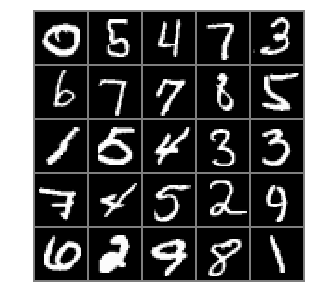

In [369]:
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.figure(figsize = (5, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
images, labels = iter(mnist_train_loader).next()
imshow(make_grid(images[:25], nrow=5, padding=1))
print(images[0].size())

In [370]:
# 1x1 invertible convolution　
# これLU分解使ってなくね？
class Invertible1x1Conv(nn.Module):
    def __init__(self, c):
        super(Invertible1x1Conv, self).__init__()
        self.conv = nn.Conv1d(c, c, kernel_size=1, stride=1, padding=0, bias=False)
        
        # 直交行列から初期値をサンプル
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # ヤコビアンが-1ではなく1であることを保証（偶数の正方行列に対しては−１，奇数なら1になるっぽい？）
        if torch.det(W) < 0:
            W[:,0] = -W[:,0]
        
        self.conv.weight.data = W.view(c, c, 1)
        
    def forward(self, z, reverse=False):
        batch_size, group_size, n_of_group = z.size()
        
        # self.conv.weightのサイズが[height, width, 1]なので調整（下のunsqueeze()も同じ）
        W = self.conv.weight.squeeze(2)
        
        # 推論処理（サンプリング）
        if reverse:
            # 推論処理なので一回逆行列を計算したら以後やらない
            if not hasattr(self, 'w_inverse'):
                W_inverse = W.inverse() # 逆行列を計算
                W_inverse = torch.autograd.Variable(W_inverse.unsqueeze(2)) # このVariableいる？
                self.W_inverse = W_inverse
            z = F.conv1d(z, self.W_inverse, bias=None, stride=1, padding=0)
            return z
        
        # 学習のためのforward処理（データ→ガウス分布方向）
        else:
            # Wは畳込みでバッチサイズ×チャネル内の要素数 回適用されるのでかける（1x1畳み込みのため）
            # バッチサイズかけるのマジ？意味分からん
            log_det_W = batch_size * n_of_group * torch.logdet(W)
            return self.conv(z), log_det_W

In [371]:
# 非線形変換に用いられるニューラルネットワーク、WaveGlowならここがnon-causal WaveNet
class NN(nn.Module):
    def __init__(self, n_in_channels, n_h_channels, n_out_channels):
        super(NN, self).__init__()
        self.cv1 = nn.Conv1d(n_in_channels, n_h_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(n_h_channels)
        self.cv2 = nn.Conv1d(n_h_channels, n_h_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(n_h_channels)
        self.cv3 = nn.Conv1d(n_h_channels, n_out_channels, kernel_size=3, stride=1, padding=1)
        self.cv3.weight.data.zero_()
        self.cv3.bias.data.zero_()
        
    def forward(self, forward_input):
        out = F.relu(self.bn1(self.cv1(forward_input)))
        out = F.relu(self.bn2(self.cv2(out)))
        return self.cv3(out)

In [372]:
# Glow本体
class Glow(nn.Module):
    def __init__(self, n_flows, n_group, n_early_every, n_early_size, affine=True):
        super(Glow, self).__init__()
        
        assert(n_group % 2 == 0)
        self.n_flows = n_flows
        self.n_group = n_group
        self.n_of_group = None
        self.n_early_every = n_early_every
        self.n_early_size = n_early_size
        self.n_h_channels = 32
        self.affine = affine
        
        self.NN = torch.nn.ModuleList()
        self.convinv = torch.nn.ModuleList()
        # 未実装　WaveGlowの実装では使われてない（恐らくWaveNet内にWeight Normがあるため）が、Glowの原論文ではactnormが用いられている
        # self.actnorm = torch.nn.ModuleList() 
        
        n_half = int(n_group/2)
        
        n_remaining_channels = n_group
        
        for k in range(n_flows):
            if k % self.n_early_every == 0 and k > 0:
                n_half = n_half - int(self.n_early_size/2)
                n_remaining_channels = n_remaining_channels - self.n_early_size
                
            self.convinv.append(Invertible1x1Conv(n_remaining_channels))
            
            # affine coupling
            if self.affine:
                self.NN.append(NN(n_half, self.n_h_channels, 2*n_half))
            # additive coupling
            else:
                self.NN.append(NN(n_half, self.n_h_channels, n_half))
                
        self.n_remaining_channels = n_remaining_channels
        
    # forward処理だが、これはデータの分布からガウス分布への写像を表す
    def forward(self, forward_input):
        assert(forward_input.size(1) % self.n_group == 0)
        self.n_of_group = int(forward_input.size(1) / self.n_group) # グループごとの点数
        
        image = forward_input.unfold(1, self.n_group, self.n_group).permute(0, 2, 1)
        output_image = []
        log_s_list = []
        log_det_W_list = []
        
        for k in range(self.n_flows):
            if k % self.n_early_every == 0 and k > 0:
                output_image.append(image[:,:self.n_early_size,:])
                image = image[:,self.n_early_size:,:]
                
            image, log_det_W = self.convinv[k](image)
            log_det_W_list.append(log_det_W)
            
            n_half = int(image.size(1)/2)
            image_0 = image[:,:n_half,:]
            image_1 = image[:,n_half:,:]
            
            output = self.NN[k](image_0)
            if self.affine:
                log_s = output[:,:n_half,:]
                b = output[:,n_half:,:]
                image_1 = torch.exp(log_s)*image_1 + b
                log_s_list.append(log_s)
            else:
                # b = output
                image_1 = image_1 + output
                log_s_list.append(0)
                
            image = torch.cat([image_0, image_1], dim=1)
            
        output_image.append(image)
        return torch.cat(output_image,dim=1), log_s_list, log_det_W_list
        
    # ガウス分布からデータへの写像、つまりサンプリング
    def infer(self, n_sample, sigma=1.0):
        assert(self.n_of_group is not None)
        image = torch.cuda.FloatTensor(n_sample, self.n_remaining_channels, self.n_of_group).normal_()
        image = torch.autograd.Variable(sigma*image) # このVariableいる？
        
        for k in reversed(range(self.n_flows)):
            n_half = int(image.size(1)/2)
            image_0 = image[:,:n_half,:]
            image_1 = image[:,n_half:,:]
            
            output = self.NN[k](image_0)
            if self.affine:
                log_s = output[:,:n_half,:]
                b = output[:,:n_half,:]
                image_1 = (image_1 - b) / torch.exp(log_s)
            else:
                # b = output
                image_1 = image_1 - output
            
            image = torch.cat([image_0, image_1], dim=1)
            
            image = self.convinv[k](image, reverse=True)
            
            if k % self.n_early_every == 0 and k > 0:
                z = torch.cuda.FloatTensor(n_sample, self.n_early_size, self.n_of_group).normal_()
                image = torch.cat([sigma*z, image], dim=1)
        
        image = image.permute(0,2,1).contiguous().view(n_sample, -1).data
        return image

In [373]:
# Glowのためのロス 
def GlowLoss(glow_output, sigma=1.0):
    z, log_s_list, log_det_W_list = glow_output
    for i, log_s in enumerate(log_s_list):
        if i == 0:
            log_s_total = torch.sum(log_s)
            log_det_W_total = log_det_W_list[i]
        else:
            log_s_total += torch.sum(log_s)
            log_det_W_total += log_det_W_list[i]
            
    # このロスもよくわからない
    # 第一項はNLLだと思うが・・・
    # 第二項以降、これだと勾配を追跡し続けている気がするのでこいつらを最小化するために学習が動かされてしまうのでは？それであってる？
    loss = torch.sum(z*z)/(2*sigma*sigma) - log_s_total - log_det_W_total
    # この正規化はよくわからない（z.size(0)はbatchsize, z.size(1)はn_group, z.size(2)はn_of_group）
    return loss/(z.size(0)*z.size(1)*z.size(2))

In [1]:
net = Glow(6, 8, 2, 2)
net = net.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad==True], lr=1e-4)
# optimizer = optim.Adam(net.parameters(), lr = learning_rate)

num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('The number of parameters:', num_trainable_params)

NameError: name 'Glow' is not defined

In [375]:
def train(train_loader):
    net.train()
    running_loss = 0
    
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        
        glow_output = net(inputs)
        loss = GlowLoss(glow_output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader)
    
    return train_loss

In [376]:
def validation(validation_loader, epoch):
    net.eval()
    running_loss = 0
    n_sample = 25
    sigma = 1.0
    sample_every = 1
    output_dir = '../../data/glow_MNIST'
    
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
  
            glow_output = net(inputs)
            loss = GlowLoss(glow_output)
            
            running_loss += loss.item()
            
    validation_loss = running_loss / len(validation_loader)
    
    if epoch % sample_every == 0:
        sampled_images = net.infer(n_sample, sigma)
        sampled_images = sampled_images.view(n_sample, 1, 28, 28)
        save_image(sampled_images.data.cpu(), '{}/{}.png'.format(output_dir, epoch), nrow=5, padding=1)
    
    return validation_loss

In [377]:
train_loss_list = []
validation_loss_list = []

n_epochs = 100
for epoch in range(n_epochs):
    train_loss = train(mnist_train_loader)
    validation_loss = validation(mnist_validation_loader, epoch)
    
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' % (epoch+1, n_epochs, train_loss, validation_loss) )

epoch[1/100] train_loss:-0.8144 validation_loss:-1.2840
epoch[2/100] train_loss:-1.3876 validation_loss:-1.5184
epoch[3/100] train_loss:-1.5039 validation_loss:-1.6123
epoch[4/100] train_loss:-1.6580 validation_loss:-1.7515
epoch[5/100] train_loss:-1.6663 validation_loss:-1.5895
epoch[6/100] train_loss:-1.7652 validation_loss:-1.8019
epoch[7/100] train_loss:-1.8679 validation_loss:-1.9204
epoch[8/100] train_loss:-1.8810 validation_loss:-1.9008
epoch[9/100] train_loss:-1.9538 validation_loss:-1.9920
epoch[10/100] train_loss:-1.9780 validation_loss:-2.0349
epoch[11/100] train_loss:-1.8718 validation_loss:-2.0906
epoch[12/100] train_loss:-2.0547 validation_loss:-2.1018
epoch[13/100] train_loss:-2.0544 validation_loss:-2.1205
epoch[14/100] train_loss:-2.1238 validation_loss:-2.2014
epoch[15/100] train_loss:-2.1611 validation_loss:-2.2306
epoch[16/100] train_loss:-2.1776 validation_loss:-2.2051
epoch[17/100] train_loss:-2.2158 validation_loss:-2.2884
epoch[18/100] train_loss:-1.8149 validat

KeyboardInterrupt: 